In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batchnum = 64
# Transform to convert images to PyTorch tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data for MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchnum, shuffle=True)

Using device: cuda


In [27]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 784)  # First layer for MNIST (28x28 images)
        self.fc2 = nn.Linear(784, 784)   # Second layer
        self.fc3 = nn.Linear(784, 10)    # Output layer for 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ExplainableNetwork:
    def __init__(self):
        self.node_inputs = {}
        self.node_activations = {}
        self.gradients = {}
        self.current_epoch = 0
    
    def initializeDictionary(self):
        for i in range(0,3):
            self.node_inputs[i] = {}
        for i in range(0,784):
            self.node_inputs[0][i] = []
        for i in range(0,784):
            self.node_inputs[1][i] = []
        for i in range(0,10):
            self.node_inputs[2][i] = []

    def input_hook(self, module, num_epochs, input, output):
        if self.current_epoch == num_epochs - 1:
            for i in range(0,input[0].size(dim=0)):
                if(np.shape(input[0][i]) == torch.Size([784])):
                    image = input[0][i].detach().reshape(28, 28).cpu().numpy()
                    self.node_inputs.append(image)

        # Store activation values (outputs)
        if isinstance(output, tuple):
            # If output is a tuple, store each element separately
            for idx, out in enumerate(output):
                self.node_activations[(module, idx)] = out.detach().tolist()
        else:
            # If output is a single tensor, store it directly
            self.node_activations[module] = output.detach().tolist()

    def backward_hook(self, module, grad_input, grad_output):
        # grad_output[0] will contain the gradient of the output with respect to the loss
        self.gradients[module] = grad_output[0].detach().tolist()

    def set_epoch(self, epoch):
        self.current_epoch = epoch

In [28]:


# Instantiate the model
model = MNISTNet().to(device)
xNetwork = ExplainableNetwork()

model.fc1.register_forward_hook(lambda module, input, output, x_Network=xNetwork: xNetwork.input_hook(module, 10, input, output))
model.fc2.register_forward_hook(lambda module, input, output, x_Network=xNetwork: xNetwork.input_hook(module, 10, input, output))
model.fc3.register_forward_hook(lambda module, input, output, x_Network=xNetwork: xNetwork.input_hook(module, 10, input, output))

# Backward hooks
model.fc1.register_backward_hook(lambda module, grad_input, grad_output, x_Network=xNetwork: xNetwork.backward_hook(module, grad_input, grad_output))
model.fc2.register_backward_hook(lambda module, grad_input, grad_output, x_Network=xNetwork: xNetwork.backward_hook(module, grad_input, grad_output))
model.fc3.register_backward_hook(lambda module, grad_input, grad_output, x_Network=xNetwork: xNetwork.backward_hook(module, grad_input, grad_output))

xNetwork.initializeDictionary()
print(len(xNetwork.node_inputs))
print(len(xNetwork.node_inputs[0]))
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
num_epochs = 10
total_batches = len(trainloader)  # Total number of batches

for epoch in range(num_epochs):
    print("Epoch " + str(epoch + 1))

    # Set the current epoch in ExplainableNetwork
    xNetwork.set_epoch(epoch)

    for batch_num, (inputs, labels) in enumerate(trainloader, 1):  # Start enumeration from 1
        inputs, labels = inputs.to(device), labels.to(device)  # Transfer to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

    # You might want to print a new line after each epoch for better readability
    print()


3
Epoch 1


c:\Users\benja\anaconda3\lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


KeyboardInterrupt: 

180000


c:\Users\benja\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


TypeError: Image data of dtype object cannot be converted to float

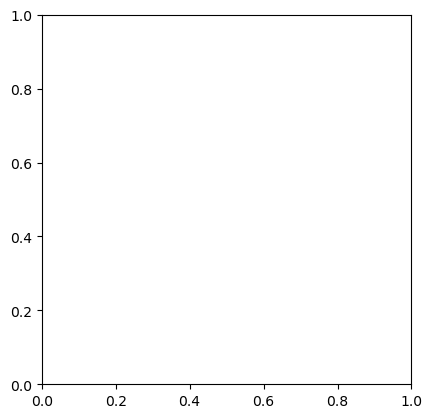

In [ ]:
print(len(xNetwork.node_inputs))
for i in range(0,63):
    plt.imshow(np.squeeze(xNetwork.node_inputs[i]), cmap='gray')
    plt.title(f"{i}")
    plt.show()

In [ ]:
model.eval()

In [ ]:
import matplotlib.pyplot as plt

# Forward pass to store activations in xNetwork
images, labels = next(iter(trainloader))

# Transfer the images and labels to the same device as the model
images, labels = images.to(device), labels.to(device)

# Now perform the forward pass
output = model(images)

# Access stored activations for the first layer
# Ensure the keys in xNetwork.node_activations match your model's layer names
fc2_activations = xNetwork.node_activations[model.fc2]


# Visualize activations
plt.figure(figsize=(10, 6))
for i, activation in enumerate(fc2_activations):
    plt.plot(activation, label=f'Neuron {i}')
plt.title('Activations of FC2 Layer')
plt.xlabel('Batch')
plt.ylabel('Activation')
plt.show()
